# Accumulator Models

Accumulator models are based on the idea that the decisions process unfolds over a period of time. In that period, evidence in favor of one or more options is accumulated. A decision is made as soon as the evidence for one option exceeds a predefined amount. There are two main families of accumulator models: diffusion models and race models. 

In [3]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import scipy.stats as stat
import scipy
import seaborn as sns
import pandas as pd
import math
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
sns.set_style("whitegrid")


Consider, for example, what has been perhaps the most experimental paradigm to which this model has been applied, the motion coherence detection. In this type of paradigm, participants are presented with an array of moving dots. All of dots are moving and at the same speed, but the degree to which they are moving _in the same direction_ changes across conditions. The Figure illustrates three hypothetical cases in which 0\%, 50\%, or 100\% of the dots are moving to the right. The direction of the coherent motion is not given to participants beforehand; on some trials, the coherent motion might be towards the left and, in other trials, towards the right. Participants are typically instructed to indicate the direction of coherent motion with the left or the right hand. In cases in which this paradigm was carried out in non-human primates, the animals typically respond by performing a saccade, i.e., by moving the eyes in the intended location.


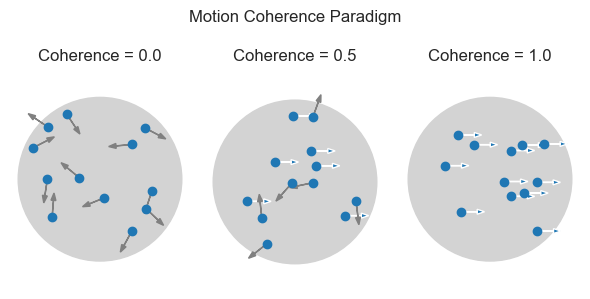

In [78]:
fig, axs = plt.subplots(1, 3, figsize = (6, 3))

points = [[x/10.0, y/10.0] for x in range(10) for y in range(10)]
points = [x for x in points if np.sqrt((x[0]-0.5)**2 + (x[1] - 0.5)**2) < 0.45]

npoints = 12
for i, coh in enumerate((0, 0.5, 1)):
    ax = axs[i]
    circle = plt.Circle((0.5,0.5), 0.5, color='lightgrey')
    ax.add_patch(circle)
    ax.axis('off')
    ax.axis('equal')
    
    # generate dots
    sub = rnd.sample(points, k = npoints)
    
    # jitter
    for p in sub:
        p[0] += rnd.uniform(-0.03, 0.03)
        p[1] += rnd.uniform(-0.03, 0.03)
        
    ax.plot([x[0] for x in sub], [x[1] for x in sub], 'o')
    n = int(npoints * coh)
    move = sub[0:n]
    non_move = sub[n:]
    
    for p in move:
        ax.arrow(p[0], p[1], 0.1, 0, head_width=0.03)
        
    for p in non_move:
        angle = rnd.uniform(0, 2 * math.pi)
        dx = math.cos(angle) * 0.1
        dy = math.sin(angle) * 0.1
        ax.arrow(p[0], p[1], dx, dy, head_width=0.03, color='grey')
        
    ax.set_title("Coherence = %.1f" % (coh,))
    
fig.suptitle("Motion Coherence Paradigm")
fig.tight_layout()
#fig.savefig("figures/motion_coherence.png", dpi=200)
plt.show()

# Ratcliff's Drift Diffusion Model


The first category of accumulator models we are going to see is called Diffusion models. These models were designed the handle what is perhaps the most prototypical case of decision-making--the case in which there are only two options, and the decided must choose one of them. This situation is technically known as a "two-alternative forced choice task", or 2AFC.

The simplest paradigm in this sense was popularized by Ratcliff (1978), and has become known as the "Drift-Diffusion Model" or DDM.

As in all accumulator models, in DDMs a decision is made by accumulating evidence over time towards one of two. Specifically, a DDM has at least three parameters:

 * The _drift rate_ $v$. This is crucial parameter in a DDM. The drift parameter captures the degree to which evidence moves, on average, towards one option or the other. 
    
 * The _decision boundary_ $A$. By convention one of the two options is associated with the value of zero while the other is associated with the boundary $A > 0$. The models begins its meandering drift at the value in between the two options, that is, $A/2$.  
    
 * The _non-decision time_ $Ter$. Although the model is designed to model the time it takes to make a decision, in real experiments the response time include other factors that have nothing to do with the decision process _per se_, such as the time necessary to move the eyes and fixate a stimulus or the time to initiate and button press. All of these factors are assumed to be constant across a single experiment, and compounded into a single factor that accounts for the "non-decision time". This parameter is called $Ter$ (from its original name, "Time for Encoding and Response").

## DDM Equation

In a DDM, evidence $E$ accumulates according to the equation:

$$ dE/dt = v + \mathcal{N}(0, s^2) $$ 

Which can also be rewritten as:

$$ dE = v \cdot dt + \mathcal{N}(0, s^2 \cdot \sqrt{dt}) $$ 

or

$$ dE = \mathcal{N}(v\cdot dt, s^2\cdot \sqrt{dt}) $$ 


The process ends when one of these conditions is reached:

* $E > A$, in which case the alternative $A$ (or 1) is selected
* $E < 0$, in which case the alternative $B$ (or 0) is selected
* $T > T_{max}$, in which case no response is selected.


In [79]:
import numpy as np
import matplotlib.pyplot as plt

class ddm():
    """
    Simulate a Drift Diffusion Model (DDM).
    """

    def __init__(self, v=1, A=1.0, z=None, s=1, ter=0.3, dt=0.01):
        # Simulation parameters
        self.v = v      # Evidence accumulation rate
        self.A = A      # Decision threshold
        self.s = s      # Noise in accumulation
        self.ter = ter  # Non-decision time (e.g., perception and motor execution)
        self.z = A/2
        if z != None:
            self.z = z*A
        self.dt = dt

    def run(self, max_time = 10):
        """Runs a trial"""
        # Set up
        drift_rate = self.v
        noise = self.s
        evidence = self.z  # Starting point for evidence accumulation
        threshold = self.A
        time = self.ter
        dt = self.dt

        # Storing variables
        rt = 0
        choice = 0
        E = [evidence]

        # Process
        while evidence < threshold and evidence > 0 and time < max_time:
            evidence += np.random.normal(drift_rate * dt, (noise**2) * np.sqrt(dt))
            E.append(evidence)
            time += dt

        if evidence >= threshold or evidence <= 0:
            rt = time
            choice = 1 if evidence > 0 else 0
        else:
            rt = np.nan      # Indicates timeout
            choice = np.nan  # No decision made

        return (E, rt, choice)


Here is an example of a trace:

In [80]:
model = ddm(v=0.5, ter=0, dt=0.001)
trace, rt, choice = model.run()
ter = [model.z for x in range(int(model.ter / model.dt))]
trace = ter + trace

And here is an example of a trace with theb $Ter$ parameter.

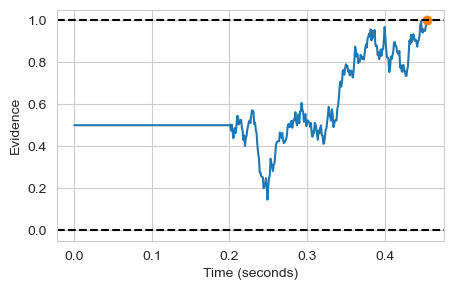

In [81]:
ter = [model.z for x in range(int(0.2 / model.dt))]
trace2 = ter + trace
x = np.arange(0, rt + model.dt/2 + 0.2, model.dt)
plt.figure(figsize=(5,3))
plt.plot(x, trace2)
plt.plot(rt + 0.2, choice, "o")
plt.ylim(-0.05,1.05)
#plt.title("Evidence Accumulation in a Drift-Diffusion Model")
plt.xlabel("Time (seconds)")
plt.ylabel("Evidence")
plt.axhline(y=0, color='k', linestyle='--')
plt.axhline(y=1, color='k', linestyle='--')
#plt.savefig("figures/trace_example.png")
plt.show()


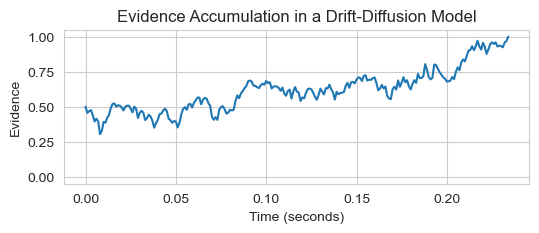

In [10]:
model = ddm(v=0.2, ter=0, dt=0.001)
trace, rt, choice = model.run()
ter = [model.z for x in range(int(model.ter / model.dt))]
trace = ter + trace
x = np.arange(0, rt + model.dt/2, model.dt)
plt.figure(figsize=(6,2))
plt.plot(x, trace)
#plt.plot(rt, choice, "o")
plt.ylim(-0.05,1.05)
plt.title("Evidence Accumulation in a Drift-Diffusion Model")
plt.xlabel("Time (seconds)")
plt.ylabel("Evidence")
#plt.axhline(y=0, color='k', linestyle='--')
#plt.axhline(y=1, color='k', linestyle='--')
#plt.savefig("figures/trace_example.png")
plt.show()


Here is an example of a DDM in action. As it is common, the top part presents an hystogram of the distribution of the response times for correct (blue) and incorrect (orange) responses across all the (simulated) trials, while the bottom plot illustrates $k$ example diffusion traces.

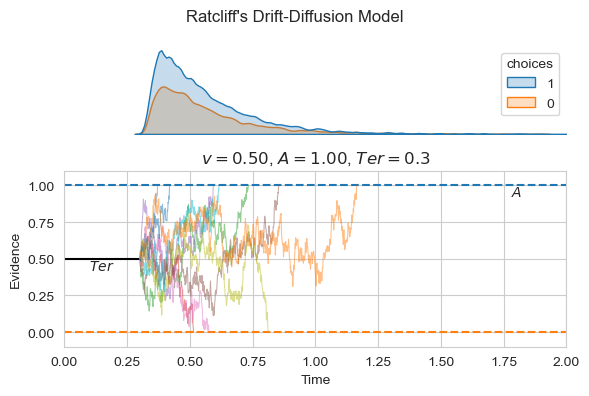

In [6]:
def run_trials(model, N, max_time=10):
    """Runs multiple trials and returns all traces, choices, and RTs"""
    runs = []
    for i in range(N):
        result = model.run(max_time)
        runs.append(result)
    return runs

model = ddm(v=0.5, A=1, s=1, ter=0.3, dt=0.001)

results = run_trials(model, 10000, max_time=100)

runs = [x[0] for x in results]
rts = [x[1] for x in results]
choices = [x[2] for x in results]

fig, (axs1, axs2) = plt.subplots(2, 1, figsize=(6,4), gridspec_kw={'height_ratios': [1, 2]})

#max_time = np.mean(rts) * 2
max_time = 2
axs1.set_xlim(0, max_time)
axs2.set_xlim(0, max_time)
#axs3.set_xlim(0, max_time)

for ax in (axs1,):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')

axs2.set_ylim(-0.1, model.A + 0.1)
axs2.set_ylabel("Evidence")
axs2.set_xlabel("Time")

# The traces

axs2.plot([0, model.ter], [model.z, model.z], "k")
axs2.plot([0, max_time], [model.A, model.A], '--')
axs2.plot([0, max_time], [0, 0], '--')

axs2.text(s=r"$Ter$", x=model.ter/2, y = model.z, ha='center', va = 'top')
axs2.text(s=r"$A$", x=max_time * 0.9, y = model.A, ha='center', va = 'top')

traces = rnd.choices(runs, k=10)

axs1.set_xlim(0, max_time)
data = pd.DataFrame({"rts":rts, "choices":choices})
sns.kdeplot(data, x="rts", hue="choices", hue_order=[1,0], 
            ax=axs1, fill=True, bw_adjust=0.3)

for trace in traces:
    n = len(trace)
    if trace[-1] > model.A:
        trace[-1] = model.A
    elif trace[-1] < 0:
        trace[-1] = 0
    x = np.arange(model.ter + model.dt, model.ter + model.dt * (n+1/2), model.dt)
    axs2.plot(x, trace, linewidth=0.75, alpha=.5)

axs2.set_title(r"$v = %.2f$, $A = %.2f$, $Ter = %.1f$" % (model.v, model.A, model.ter)) 

fig.suptitle("Ratcliff's Drift-Diffusion Model")
fig.tight_layout()
#plt.savefig('figures/newddm.png')
plt.show()

## Decision Boundary $A$ and Speed-Accuracy Trade-Off

The speed-accuracy trade-off can be modeled by adjusting the decision boundary $A$.

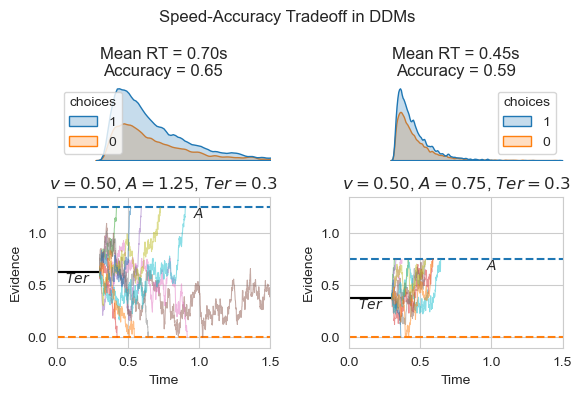

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(6,4), gridspec_kw={'height_ratios': [1, 2]})

max_time = 1.5
N = 10000

for i, boundary in enumerate((1.25, 0.75)):
    model = ddm(v = 0.5, ter = 0.3, A = boundary, dt=0.001) 
    runs = run_trials(model, N)

    traces = [x[0] for x in runs]
    rts = [x[1] for x in runs]
    choices = [x[2] for x in runs]

    times_a = [rts[ii] for ii in range(N) if choices[ii] == 1]
    times_0 = [rts[ii] for ii in range(N) if choices[ii] == 0]
    
    #print((len(times_a), len(times_0)))
    ax1, ax2 = axes[:,i]
    ax1.set_xlim(0, max_time)
    ax2.set_xlim(0, max_time)

    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax1.axis('off')
    
    ax2.set_ylim(-0.1, 1.35)
    ax2.set_ylabel("Evidence")
    ax2.set_xlabel("Time")

    # The traces

    ax2.plot([0, model.ter], [model.z, model.z], "k")
    ax2.plot([0, max_time], [model.A, model.A], '--')
    ax2.plot([0, max_time], [0, 0], '--')
    ax2.plot([0, model.ter], [model.z, model.z], "k")

    ax2.text(s=r"$Ter$", x = model.ter/2, y = model.z, ha = 'center', va = 'top')
    ax2.text(s=r"$A$", x = max_time - 0.5, y = model.A, ha = 'center', va = 'top')

    subset = rnd.choices([x for x in traces if x[-1] < max_time], k = 10)

    for trace in subset:
        n = len(trace)
        if trace[-1] > model.A:
            trace[-1] = model.A
        elif trace[-1] < 0:
            trace[-1] = 0
        x = np.arange(model.ter + model.dt, model.ter + model.dt * (n+1/2), model.dt)
        ax2.plot(x, trace, linewidth=0.75, alpha=.5)
    
    meanrt = np.mean(rts)
    meanacc = np.mean([x for x in choices if choice in [0,1]])
    ax1.set_title("Mean RT = %.2fs\nAccuracy = %.2f" % (meanrt, meanacc)) 
    ax2.set_title("$v = %.2f$, $A = %.2f$, $Ter = %.1f$" % (model.v, model.A, model.ter)) 
    data = pd.DataFrame({"rts" : rts, "choices" : choices})
    sns.kdeplot(data, x="rts", hue="choices", hue_order=[1,0], 
            ax=ax1, fill=True, bw_adjust=0.3)


fig.suptitle("Speed-Accuracy Tradeoff in DDMs")
fig.tight_layout()
#plt.savefig("figures/speed_accuracy_tradeoff.png", dpi=200)
plt.show()


## Wiener Processes, Mean Accuracies, and Mean Response Times

Although it was proposed independently of it, Ratcliff's drift diffusion model is mathematically equivalent to a mathematical construct known as a Wiener diffusion process, which was introduced by physicist Norbert Wiener to simulate brownian motion (the motion of particles suspended in a liquid) over time.    

Because of this, it was possible to use the mathematical tools of physics to derive exact formulas for the shape of response and response times distributions of drift-diffusion models.

In particular, Wagenmakers and colleagues demonstrated that the mean proportion of trials in which the drift process cross the lowest boundary (i.e., $E<0$) can be expressed as:

$$    P(E<0) = \frac{1}{1 + e^{Av}} $$

And, because there are only two possible responses, the probability that the drift diffusion process will cross the $A$ boundary is:

$$    P(E>A) = 1 - P(E < 0) = 1 - \frac{1}{1 + e^{Av}} $$ 

Finally, the mean response time $\overline{RT}$ is given by:

$$    \overline{RT} = \frac{A}{2v} \times \frac{1-e^{-Av}}{1+e^{-Av}} + T_{ER} $$

These functions can be easily coded:

In [234]:
def mean_accuracy(A, v):
    """Mean accuracy of a DDM"""
    return 1 - 1/(1 + np.exp(A * v))

def mean_rt(A, v, ter):
    """Mean RT of a DDM"""
    x = A/(2 * v)
    y = -A * v
    return ter + x * (1 - np.exp(y)) / (1 + np.exp(-A*v))

And we can verify that they match the empirical predictions. For example, here are the predicted results for the DDM used above:

In [235]:
print("Mean accuracy for A = .75, v = 0.5............", round(mean_accuracy(0.75, 0.5), 3))
print("Mean RT for for A = .75, v = 0.5, Ter = 0.3...", round(mean_rt(0.75, 0.5, 0.3), 3))

Mean accuracy for A = .75, v = 0.5............ 0.593
Mean RT for for A = .75, v = 0.5, Ter = 0.3... 0.439


## Response Bias $z$

Sometimes one option is intrinsically favored. This can be, for example, for innate response preferences (e.g., hand dominance), for prior knowledge (e.g., cued response direction), or for reward incentives (higher payoff to get it right). All of these circumstances can be modeled by adding one parameter that shifts the starting position of the trace.

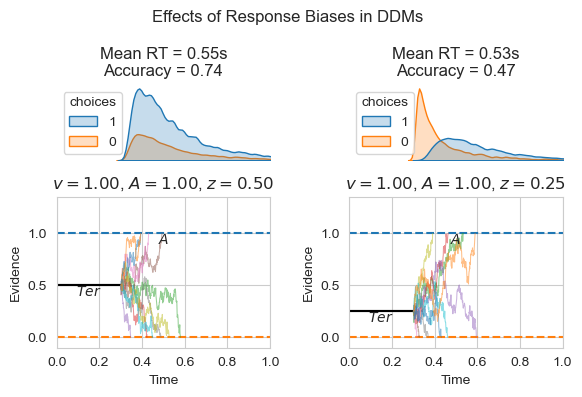

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(6,4), gridspec_kw={'height_ratios': [1, 2]})

max_time = 1.0
N = 10000

for i, z in enumerate((0.5, 0.25)):
    model = ddm(v = 1, ter = 0.3, A = 1.0, z=z, dt=0.001) 
    runs = run_trials(model, N)

    traces = [x[0] for x in runs]
    rts = [x[1] for x in runs]
    choices = [x[2] for x in runs]

    times_a = [rts[ii] for ii in range(N) if choices[ii] == 1]
    times_0 = [rts[ii] for ii in range(N) if choices[ii] == 0]
    
    #print((len(times_a), len(times_0)))
    ax1, ax2 = axes[:,i]
    ax1.set_xlim(0, max_time)
    ax2.set_xlim(0, max_time)

    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax1.axis('off')
    
    ax2.set_ylim(-0.1, 1.35)
    ax2.set_ylabel("Evidence")
    ax2.set_xlabel("Time")

    # The traces

    ax2.plot([0, model.ter], [model.z, model.z], "k")
    ax2.plot([0, max_time], [model.A, model.A], '--')
    ax2.plot([0, max_time], [0, 0], '--')
    ax2.plot([0, model.ter], [model.z, model.z], "k")

    ax2.text(s=r"$Ter$", x = model.ter/2, y = model.z, ha = 'center', va = 'top')
    ax2.text(s=r"$A$", x = max_time - 0.5, y = model.A, ha = 'center', va = 'top')

    subset = rnd.choices(traces, k = 10)

    for trace in subset:
        n = len(trace)
        if trace[-1] > model.A:
            trace[-1] = model.A
        elif trace[-1] < 0:
            trace[-1] = 0
        x = np.arange(model.ter + model.dt, model.ter + model.dt * (n+1/2), model.dt)
        ax2.plot(x, trace, linewidth=0.75, alpha=.5)
    
    meanrt = np.mean(rts)
    meanacc = np.mean([x for x in choices if choice in [0,1]])
    ax1.set_title("Mean RT = %.2fs\nAccuracy = %.2f" % (meanrt, meanacc)) 
    ax2.set_title("$v = %.2f$, $A = %.2f$, $z = %.2f$" % (model.v, model.A, model.z)) 
    data = pd.DataFrame({"rts" : rts, "choices" : choices})
    sns.kdeplot(data, x="rts", hue="choices", hue_order=[1,0], 
            ax=ax1, fill=True, bw_adjust=0.3)

fig.suptitle("Effects of Response Biases in DDMs")
fig.tight_layout()
#plt.savefig("figures/response_biases.png", dpi=200)
plt.show()


## Modeling errors

We have seen above that Ratcliff's model is commonly applied by coding the two options as the correct and incorrect response to a given stimulus, independently of the response. In this case, the drift parameter can be easily understood as a measure of decision difficulty: the easier it is to make a decision, the quicker the response times and the more likely the correct response is to be selected.

One noteworthy limitation of this approach, however, is that errors, in human experiments (and likely in primate experiments as well) exhibit different distributions of response times. The nature of this difference depends a bit on the task. When the experiment stresses quick response times.

These apparently complicated pattern can be captured by adding another source of inter-trial variability to the model---specifically, by making the drift rate vary randomly across trials. In this case, the drift rate is not constant across trials, but is drawn from a normal distribution with mean $\mu_v$ and standard deviation $\sigma_v$: $v \sim \mathcal{N}(\mu_v, \sigma_v)$

              rts
choices          
0        1.044545
1        0.827596


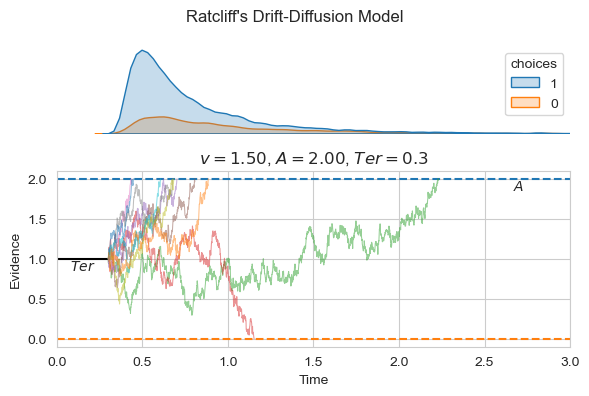

In [248]:
class shin_ddm(ddm):
    """
    Simulate a Drift Diffusion Model (DDM).
    """

    def __init__(self, v=1, vsd=0.25, A=1, z=None, s=1, ter=0.3, dt=0.01):
        super(shin_ddm, self).__init__(v, A, z, s, ter, dt)
        self.vsd = vsd

    def run(self, max_time = 10):
        """Runs a trial"""
        # Set up
        drift_rate = np.random.normal(self.v, self.vsd)
        noise = self.s
        evidence = self.z  # Starting point for evidence accumulation
        threshold = self.A
        time = self.ter
        dt = self.dt

        # Storing variables
        rt = 0
        choice = 0
        E = [evidence]

        # Process
        while evidence < threshold and evidence > 0 and time < max_time:
            evidence += np.random.normal(drift_rate*dt, (noise**2) * np.sqrt(dt))
            E.append(evidence)
            time += dt

        if evidence >= threshold or evidence <= 0:
            rt = time
            choice = 1 if evidence > 0 else 0
        else:
            rt = np.nan      # Indicates timeout
            choice = np.nan  # No decision made

        return (E, rt, choice)
        


model = shin_ddm(v=1.5, vsd=2, A=2, s=1, ter=0.3, dt=0.001)

results = run_trials(model, 10000, max_time=50)

runs = [x[0] for x in results]
rts = [x[1] for x in results]
choices = [x[2] for x in results]

fig, (axs1, axs2) = plt.subplots(2, 1, figsize=(6,4), gridspec_kw={'height_ratios': [1, 2]})

max_time = 3

axs1.set_xlim(0, max_time)
axs2.set_xlim(0, max_time)
#axs3.set_xlim(0, max_time)

for ax in (axs1,):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')

axs2.set_ylim(-0.1, model.A + 0.1)
axs2.set_ylabel("Evidence")
axs2.set_xlabel("Time")

# The traces

axs2.plot([0, model.ter], [model.z, model.z], "k")
axs2.plot([0, max_time], [model.A, model.A], '--')
axs2.plot([0, max_time], [0, 0], '--')

axs2.text(s=r"$Ter$", x=model.ter/2, y = model.z, ha='center', va = 'top')
axs2.text(s=r"$A$", x=max_time * 0.9, y = model.A, ha='center', va = 'top')

traces = rnd.choices(runs, k=10)

axs1.set_xlim(0, max_time)
data = pd.DataFrame({"rts":rts, "choices":choices})
sns.kdeplot(data, x="rts", hue="choices", hue_order=[1,0], 
            ax=axs1, fill=True, bw_adjust=0.3)

for trace in traces:
    n = len(trace)
    if trace[-1] > model.A:
        trace[-1] = model.A
    elif trace[-1] < 0:
        trace[-1] = 0
    x = np.arange(model.ter + model.dt, model.ter + model.dt * (n+1/2), model.dt)
    axs2.plot(x, trace, linewidth=0.75, alpha=.5)

print(data.groupby("choices").agg("mean"))

axs2.set_title(r"$v = %.2f$, $A = %.2f$, $Ter = %.1f$" % (model.v, model.A, model.ter)) 

fig.suptitle("Ratcliff's Drift-Diffusion Model")
fig.tight_layout()
plt.savefig('figures/newddm.png')
plt.show()

# Race Models

Race models have only one boundary.

In [99]:
class race():
    """
    Simulate a race diffusion Model.
    """

    def __init__(self, A=1.0, v=[1], z=None, s=1, ter=0.3, dt=0.01):
        # Simulation parameters
        self.v = v      # Evidence accumulation rates
        self.A = A      # Decision threshold
        self.s = s      # Noise in accumulation
        self.ter = ter  # Non-decision time (e.g., perception and motor execution)
        self.dt = dt

    def run(self, max_time = 10):
        """Runs a trial"""
        # Set up
        rates = self.v
        noise = self.s
        t = self.ter/self.dt
        threshold = self.A
        time = self.ter
        dt = self.dt

        # Storing variables
        rt = 0
        choice = None
        
        E = [np.zeros(len(rates))]
        
        for i in range(int(t)):
            E.append(np.zeros(len(rates)))  # Starting point for evidence accumulation
        
        # Process
        
        while choice is None and time < max_time:
            newE = np.zeros(len(rates))
            oldE = E[-1]
            for i, drift in enumerate(rates):
                dE = np.random.normal(drift * dt, (noise**2) * np.sqrt(dt))
                newE[i] = oldE[i] + dE 
                if newE[i] > threshold:
                    choice = i
            E.append(newE)
            time += dt

        if choice is not None:
            rt = time
        else:
            rt = time      # Indicates timeout
            choice = np.nan  # No decision made

        return (E, rt, choice)


Here is a visualization

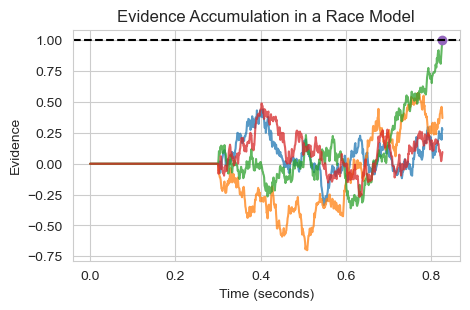

In [110]:
model = race(v=[0.2, 1, 0.7, 0.5], dt=0.001)
E, rt, choice = model.run()
xtime = np.arange(0, rt + model.dt/2, model.dt)
plt.figure(figsize=(5,3))
plt.plot(xtime, E, alpha=0.75)
plt.plot(rt, model.A, "o")
plt.title("Evidence Accumulation in a Race Model")
plt.xlabel("Time (seconds)")
plt.ylabel("Evidence")
plt.axhline(y=1, color='k', linestyle='--', alpha=1)
plt.savefig("figures/race_example.png")
plt.show()

In [ ]:

# Define parameters
TIME_STEPS = 1000  # Maximum number of time steps
DRIFT_A = 0.01  # Drift rate for option A
DRIFT_B = 0.008  # Drift rate for option B
NOISE_S = 0.05  # Noise level
THRESHOLD = 1.0  # Decision threshold

# Initialize evidence accumulators
evidence_A = np.zeros(TIME_STEPS)
evidence_B = np.zeros(TIME_STEPS)
response_time = TIME_STEPS  # Default to max steps if no decision occurs
chosen_option = None

def simulate_race_model():
    global response_time, chosen_option
    for t in range(1, TIME_STEPS):
        evidence_A[t] = evidence_A[t-1] + DRIFT_A + np.random.normal(0, NOISE_S)
        evidence_B[t] = evidence_B[t-1] + DRIFT_B + np.random.normal(0, NOISE_S)
        
        if evidence_A[t] >= THRESHOLD:
            response_time = t
            chosen_option = "A"
            break
        elif evidence_B[t] >= THRESHOLD:
            response_time = t
            chosen_option = "B"
            break

simulate_race_model()

# Plot results
plt.plot(evidence_A[:response_time], label="Option A")
plt.plot(evidence_B[:response_time], label="Option B")
plt.axhline(THRESHOLD, color='k', linestyle='--', label="Threshold")
plt.xlabel("Time")
plt.ylabel("Accumulated Evidence")
plt.legend()
plt.title(f"Chosen Option: {chosen_option}, Response Time: {response_time}")
plt.show()

In [10]:
np.zeros(8)

array([0., 0., 0., 0., 0., 0., 0., 0.])

### The Linear Ballistic Accumulator model 

The LBA is a random-ray model. The drift rate is the angle at which the ray is moving towards the boundary. Inter-trial variability comes from teh angle being drawn from a normal distribution.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
class LBA:
    """Brown and Heathcote's Linear Ballistic Accumulator""" 
    def __init__(self, v, a, ter, vsd=0.1):
        """Initializes the main parameters"""
        self.v = v
        self.a = a
        self.ter = ter
        self.vsd = vsd
        
    def trial(self):
        """Simulates a single trial as a random ray"""
        slope = np.max((0.000000001, np.random.normal(self.v, self.vsd)))
        intersect = self.a / slope
        return (self.ter + intersect, self.a)
    
    def run(self, n = 1000):
        """Simulates N trials"""
        traces = []
        for i in range(n):
            traces.append(self.trial())
            
        return traces

Here is an illustration of the LBA in action

In [ ]:
import pandas as pd
import seaborn as sns
lba = LBA(v = 0.75, a = 1, ter=0.3, vsd=0.3)

traces = lba.run(1000)

rts = [x[0] for x in traces]
fig, (axs1, axs2) = plt.subplots(2, 1, figsize=(6,4), gridspec_kw={'height_ratios': [1, 1]})
max_time = 2

axs1.set_xlim(0, max_time)
axs2.set_xlim(0, max_time)

for ax in (axs1,):#, axs3):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')

axs2.set_ylim(-0.2, lba.a + 0.2)
axs2.set_ylabel("Evidence")
axs2.set_xlabel("Time")

# The traces

axs2.plot([0, max_time], [lba.a, lba.a], '--')
axs2.plot([0, max_time], [0, 0], '--')
axs2.plot([0, lba.ter], [0, 0], "k")

axs2.text(s=r"$Ter$", x=lba.ter/2, y = 0, ha='center', va = 'bottom')
axs2.text(s=r"$A$", x=max_time - 0.5, y = lba.a, ha='center', va = 'top')

subset = rnd.sample([x for x in traces if x[0] < max_time], k = 10)

for trace in subset:
    axs2.plot([lba.ter, trace[0]], [0, trace[1]], alpha=0.5)

bins = [x/2 for x in range(0, 2*max_time)]
axs2.set_title(r"$v = %.2f$, $A = %.2f$, $Ter = %.1f$" % (lba.v, lba.a, lba.ter)) 
kwargs = dict(histtype='stepfilled', alpha=0.2, density=False, bins=bins, ec="k")
#axs1.hist([t[0] for t in traces], **kwargs)
print(rts[1:50])
data = pd.DataFrame({'rts':rts})
print(data)
#sns.kdeplot(data=data, x='rts', ax=axs1)
#axs3.hist((times_a, times_0), **kwargs)
fig.suptitle("Brown & Heathcote's Linear Ballistic Accumulator")
fig.tight_layout()
plt.savefig("figures/lba.png", dpi=200)
plt.show()
#sns.histplot(np.array(rts))

In [ ]:
sns.histplot(rts)

# Fitting an Accumulator Model

Now we are going to demonstrate how we can fit a DDM model to real data.   


In [11]:
data = pd.read_csv('simon_data.csv')
data

FileNotFoundError: [Errno 2] No such file or directory: 'simon_data.csv'

We are going to plot the histogram of response times together with the estimated probability distrubution

In [ ]:
ax = sns.histplot(data, x="RT", kde=True)
ax.set_title("Histogram of Response Times from Simon Task")
plt.show()


## Loss Function

Since we are going to reproduce the distribution of RTs, we are going to use the Kullback-Leiber divergence $D_{KL}$:

$$ D_{KL}(P||Q) = \int_x P(x) \times \log \frac{P(x)}{Q(x)}$$

The KL divergence measures hhow much the distribution $P$ difference from $Q$; formally, it can be interpreted as the increase _surprise_ that is observed if one replaces $P$ with $Q$. In our case, $Q$ is the model's prediction and $P$ is the empirical data:

$$ D_{KL}(P||Q) = \int_x P_{data}(x) \times \log \frac{P_{data}(x)}{P_{model}(x)}$$

In practice, we always deal with finite distributions and samples:

$$ D_{KL}(P||Q) = \sum_{i=1}^n   P_{data}(i) \times \log \frac{P_{data}(i)}{P_{model}(i)} $$

## Computing Probability Densities

Note that the KL function is computed over a series of _probabilities_, which must be between 0 and 1 (and must be strictly > 0, because of the logarithm and the fraction). What we do have is instead a histogram of values. To turn histograms into probabilities, we can use a _kernel density estimator_ (KDE):

In [ ]:
empirical_kde = stat.gaussian_kde(data.RT, bw_method=1)
x = np.linspace(0, 5000, 100)
empirical_dist = [empirical_kde(i) for i in x]
plt.plot(x, empirical_dist)
plt.title("Empirical Distribution of RTs from KDE")
plt.xlabel("RT")
plt.ylabel("Probability")
plt.show()

Now we can define our loss function. It takes a vector of parameters $\theta = {v, A, T_{ER}, SD_v}$ and does the following:

* It creates a new LBA model with the parameters in $\theta$;
* Runs the LBA model 10,000 times and collectes the response times.
* Computes the distribution fo RTs using Kernel Density estimation/
* Computes the KL divergence using the probability values estimated from the KDE of the empirical data and the KDE of the model's responses
* Returns the value of the KL divergence.

In [ ]:
def loss(X):
    v, ter, a, vsd = X 
    lba = LBA(v = v, ter=ter, a= a, vsd = vsd)
    traces = lba.run(10000)
    predicted = [x[0]*1000 for x in traces]
    model_kde = stat.gaussian_kde(np.array(predicted), bw_method=100)
    model_dist = [model_kde(x) for x in np.linspace(0, 5000, 100)]
    
    return stat.entropy(empirical_dist, model_dist)

aspace = np.linspace(0.5, 5.5, 11)
vspace = np.linspace(0, 5, 11)
matrix = np.zeros((len(terspace), len(vspace)))

for i, a in enumerate(aspace):
    for j, v in enumerate(vspace):
        matrix[i,j] = loss(np.array([v, 0.35, a, 0.06]))


And now we can visualize the results

NameError: name 'ddm' is not defined

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix, interpolation='nearest')
fig.colorbar(cax)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + [str(round(x,2)) for x in terspace])
ax.set_yticklabels([''] + [str(round(x, 2)) for x in vspace])
ax.set_ylabel(r"Decision boundary $A$ ")
ax.set_xlabel(r"Drift rate $v$ ")
ax.set_title("KL Divergence of LBA Model by Parameter Combination")
plt.show()

With the loss function in place, we now can apply, again, standard optimization techniques. This time we are going to use _Powell_'s method (instead o the Nelder-Mead algorithm) because it allows for the specification fo boundaries for the space of each parameter. These boundaries are needed because some values are constrained. For example, all parameter values must be positive.

In [ ]:
res = scipy.optimize.minimize(loss, x0=[0.1, 3, 3,1],
                              method="Powell", bounds=[[0.0001, 5], 
                                                       [0, 1], 
                                                       [0.0001, 5],
                                                       [0.0001,1]],
                             tol=0.1)
print(res)

And now, we can visualize how well our midel's distribution of RTs matches the results from the Simon experiment.

In [ ]:
# Generate high-density RT space for better viz
rtx = np.linspace(0, 4000, 100)

# Re-generate empirical RT Distribution

empirical_dist = [empirical_kde(i) for i in rtx]


# RT Dist with default values

lba = LBA(v=3, ter=2, a=1, vsd=0.1)
traces = lba.run(10000)
predicted = [x[0]*1000 for x in traces]
labdist = stat.gaussian_kde(predicted, bw_method=100)
default_dist = [labdist(i) for i in rtx]

# RT Dist with Optimized values

vstar, terstar, astar, vsdstar = res.x
print(res.x)

lbastar = LBA(v=vstar, ter=terstar, a=astar, vsd=vsdstar)
traces = lbastar.run(10000)
predicted = [x[0] * 1000 for x in traces]
labdist = stat.gaussian_kde(predicted, bw_method=100)
optimized_dist = [labdist(i) for i in rtx]

# Compute KL

kl = stat.entropy(empirical_dist, optimized_dist)
print(kl)

plt.plot(rtx, empirical_dist, label="Empirical Data")
#plt.plot(rtx, default_dist, label="LBA Prediction (Default Parameters)")
plt.plot(rtx, optimized_dist, label="LBA Prediction (Fitted Parameters)")
#ax.set_title("simulated LBA data")
plt.legend()
plt.suptitle("LBA Fitting ($KL = %.2f$)" % (kl))
plt.title("$v = %.2f, T_{ER} = %.2f, A= %.2f, SD_v = %.2f$" % (vstar, terstar, astar, vsdstar))
plt.xlabel("RT")
plt.ylabel("Probability")
plt.show()

## Simulations

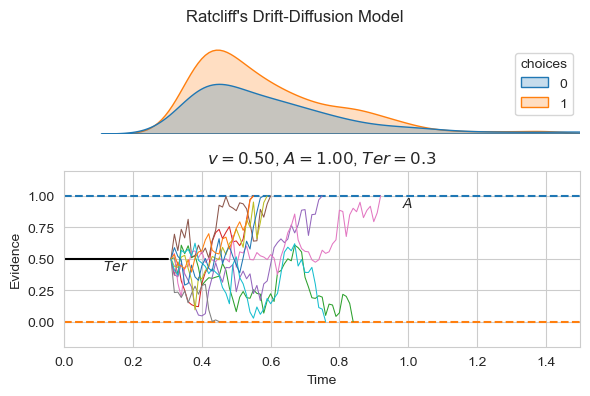

<Figure size 640x480 with 0 Axes>

In [313]:
fig, (axs1, axs2) = plt.subplots(2, 1, figsize=(6,4), gridspec_kw={'height_ratios': [1, 2]})

max_time = 1.5

axs1.set_xlim(0, max_time)
axs2.set_xlim(0, max_time)
#axs3.set_xlim(0, max_time)

for ax in (axs1,):#, axs3):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    #ax.set_ylim(0, 2000)`
    #axs3.set_ylim(0, 10)

axs2.set_ylim(-0.2, model.A + 0.2)
axs2.set_ylabel("Evidence")
axs2.set_xlabel("Time")

# The traces

axs2.plot([0, model.ter], [model.z, model.z], "k")
axs2.plot([0, max_time], [model.A, model.A], '--')
axs2.plot([0, max_time], [0, 0], '--')

axs2.text(s=r"$Ter$", x=model.ter/2, y = model.z, ha='center', va = 'top')
axs2.text(s=r"$A$", x=max_time - 0.5, y = model.A, ha='center', va = 'top')
#axs2.text(s=r"$0$", x=max_time - 0.5, y = 0, ha='center', va = 'bottom')

traces = rnd.choices(runs, k=10)

sns.kdeplot(data, x="rts", hue="choices", ax=axs1, fill=True)

for trace in traces:
    n = len(trace)
    if trace[-1] > model.A:
        trace[-1] = model.A
    elif trace[-1] < 0:
        trace[-1] = 0
    x = np.arange(model.ter + model.dt, model.ter + model.dt * (n+1/2), model.dt)
    axs2.plot(x, trace, linewidth=0.75)

axs2.set_title(r"$v = %.2f$, $A = %.2f$, $Ter = %.1f$" % (model.v, model.A, model.ter)) 
kwargs = dict(histtype='stepfilled', alpha=0.2, density=False, bins=bins, ec="k")

fig.suptitle("Ratcliff's Drift-Diffusion Model")
fig.tight_layout()
plt.show()
plt.savefig('figures/newddm.jpg')

900

In [283]:
1 / (1 + np.exp(-1))

0.7310585786300049